# SageMaker Serverless Inference
## XGBoost Regression Example

Amazon SageMaker Serverless Inference is a purpose-built inference option that makes it easy for customers to deploy and scale ML models. Serverless Inference is ideal for workloads which have idle periods between traffic spurts and can tolerate cold starts. Serverless endpoints also automatically launch compute resources and scale them in and out depending on traffic, eliminating the need to choose instance types or manage scaling policies.

With Serverless Inference, you only pay for the compute capacity used to process inference requests, billed by the millisecond, and the amount of data processed. The compute charge depends on the memory configuration you choose.

For this notebook we'll be working with the SageMaker XGBoost Algorithm to train a model and then deploy a serverless endpoint. We will be using the public S3 Abalone regression dataset for this example.

<b>Notebook Setting</b>
- <b>SageMaker Classic Notebook Instance</b>: ml.m5.xlarge Notebook Instance & conda_python3 Kernel
- <b>SageMaker Studio</b>: Python 3 (Data Science)
- <b>Regions Available</b>: SageMaker Serverless Inference is currently available in the following regions: US East (Northern Virginia), US East (Ohio), US West (Oregon), EU (Ireland), Asia Pacific (Tokyo) and Asia Pacific (Sydney)

## Table of Contents
- Setup
- Model Training
- Deployment
    - Model Creation
    - Endpoint Configuration (Adjust for Serverless)
    - Serverless Endpoint Creation
    - Endpoint Invocation
- Cleanup

## Setup

For testing you need to properly configure your Notebook Role to have <b>SageMaker Full Access</b>.

Let's start by installing preview wheels of the Python SDK, boto and aws cli

In [ ]:
! pip install sagemaker botocore boto3 awscli --upgrade

In [2]:
# Setup clients
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

### SageMaker Setup
To begin, we import the AWS SDK for Python (Boto3) and set up our environment, including an IAM role and an S3 bucket to store our data.

In [3]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator

boto_session = boto3.session.Session()
region = boto_session.region_name
print(region)

sagemaker_session = sagemaker.Session()
base_job_prefix = "xgboost-example"
role = sagemaker.get_execution_role()
print(role)

default_bucket = sagemaker_session.default_bucket()
s3_prefix = base_job_prefix

training_instance_type = "ml.m5.xlarge"

us-west-2
arn:aws:iam::328296961357:role/service-role/AmazonSageMaker-ExecutionRole-20191125T182032


Retrieve the Abalone dataset from a publicly hosted S3 bucket.

In [4]:
# retrieve data
! curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/uci_abalone/train_csv/abalone_dataset1_train.csv > abalone_dataset1_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131k  100  131k    0     0   240k      0 --:--:-- --:--:-- --:--:--  240k


Upload the Abalone dataset to the default S3 bucket.

In [5]:
# upload data to S3
!aws s3 cp abalone_dataset1_train.csv s3://{default_bucket}/xgboost-regression/train.csv

upload: ./abalone_dataset1_train.csv to s3://sagemaker-us-west-2-328296961357/xgboost-regression/train.csv


## Model Training

Now, we train an ML model using the XGBoost Algorithm. In this example, we use a SageMaker-provided [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) container image and configure an estimator to train our model.

In [6]:
from sagemaker.inputs import TrainingInput

training_path = f"s3://{default_bucket}/xgboost-regression/train.csv"
train_input = TrainingInput(training_path, content_type="text/csv")

In [7]:
model_path = f"s3://{default_bucket}/{s3_prefix}/xgb_model"

# retrieve xgboost image
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)

# Configure Training Estimator
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    output_path=model_path,
    sagemaker_session=sagemaker_session,
    role=role,
)

# Set Hyperparameters
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)

Train the model on the Abalone dataset.

In [ ]:
# Fit model
xgb_train.fit({"train": train_input})

## Deployment

After training the model, retrieve the model artifacts so that we can deploy the model to an endpoint.

In [9]:
# Retrieve model data from training job
model_artifacts = xgb_train.model_data
model_artifacts

's3://sagemaker-us-west-2-328296961357/xgboost-example/xgb_model/sagemaker-xgboost-2021-12-10-20-03-35-522/output/model.tar.gz'

### Model Creation
Create a model by providing your model artifacts, the container image URI, environment variables for the container (if applicable), a model name, and the SageMaker IAM role.

In [10]:
from time import gmtime, strftime

model_name = "xgboost-serverless" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)

# dummy environment variables
byo_container_env_vars = {"SAGEMAKER_CONTAINER_LOG_LEVEL": "20", "SOME_ENV_VAR": "myEnvVar"}

create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": byo_container_env_vars,
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: xgboost-serverless2021-12-10-20-07-47
Model Arn: arn:aws:sagemaker:us-west-2:328296961357:model/xgboost-serverless2021-12-10-20-07-47


### Endpoint Configuration Creation

This is where you can adjust the <b>Serverless Configuration</b> for your endpoint. The current max concurrent invocations for a single endpoint, known as <b>MaxConcurrency</b>, can be any value from <b>1 to 50</b>, and <b>MemorySize</b> can be any of the following: <b>1024 MB, 2048 MB, 3072 MB, 4096 MB, 5120 MB, or 6144 MB</b>.

In [11]:
xgboost_epc_name = "xgboost-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=xgboost_epc_name,
    ProductionVariants=[
        {
            "VariantName": "byoVariant",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-west-2:328296961357:endpoint-config/xgboost-serverless-epc2021-12-10-20-07-48


### Serverless Endpoint Creation
Now that we have an endpoint configuration, we can create a serverless endpoint and deploy our model to it. When creating the endpoint, provide the name of your endpoint configuration and a name for the new endpoint.

In [12]:
endpoint_name = "xgboost-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=xgboost_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-west-2:328296961357:endpoint/xgboost-serverless-ep2021-12-10-20-07-48


Wait until the endpoint status is InService before invoking the endpoint.

In [13]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'xgboost-serverless-ep2021-12-10-20-07-48',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:328296961357:endpoint/xgboost-serverless-ep2021-12-10-20-07-48',
 'EndpointConfigName': 'xgboost-serverless-epc2021-12-10-20-07-48',
 'ProductionVariants': [{'VariantName': 'byoVariant',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:04889b02181f14632e19ef6c2a7d74bfe699ff4c7f44669a78834bc90b77fe5a',
     'ResolutionTime': datetime.datetime(2021, 12, 10, 20, 7, 49, 119000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2021, 12, 10, 20, 7, 48, 532000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 12, 10, 

### Endpoint Invocation
Invoke the endpoint by sending a request to it. The following is a sample data point grabbed from the CSV file downloaded from the public Abalone dataset.

In [14]:
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
    ContentType="text/csv",
)

print(response["Body"].read())

b'4.566554546356201'


In [34]:
import time
import numpy as np

In [60]:
%%time
invocation_number = 100
latency_array = []

for i in range(invocation_number):
    tic = time.time()
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
        ContentType="text/csv")
    toc = time.time()
    latency_array.append(toc-tic)

CPU times: user 1.13 s, sys: 40.3 ms, total: 1.17 s
Wall time: 12 s


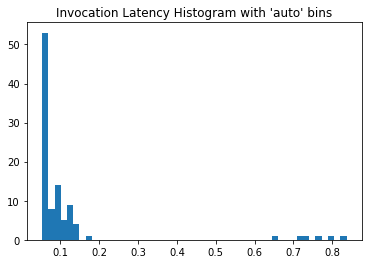

In [61]:
#let us see latency distribution on a WARM serverless inference
import matplotlib.pyplot as plt
latency_array_np = np.array(latency_array)
_ = plt.hist(latency_array_np, bins='auto')  # arguments are passed to np.histogram
plt.title("Invocation Latency Histogram with 'auto' bins")
plt.show()

## Cold Endpoint invocation
If we wait 10-15 minutes and re-run the above two cells, we will see 1st invocation taking longer than subsequent ones.

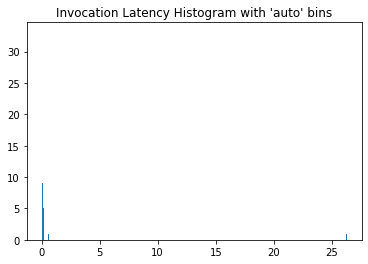

In [63]:
#let us see latency distribution on a COLD serverless inference
import matplotlib.pyplot as plt
latency_array_np = np.array(latency_array)
_ = plt.hist(latency_array_np, bins='auto')  # arguments are passed to np.histogram
plt.title("Invocation Latency Histogram with 'auto' bins")
plt.show()

In [65]:
print(latency_array[0:5])

[26.253332376480103, 0.0899045467376709, 0.16146612167358398, 0.12996506690979004, 0.1311647891998291]


## Clean Up
Delete any resources you created in this notebook that you no longer wish to use.

In [15]:
#client.delete_model(ModelName=model_name)
#client.delete_endpoint_config(EndpointConfigName=xgboost_epc_name)
#client.delete_endpoint(EndpointName=endpoint_name)